Steven Black

Due 09-27-2020

IS 678 Data Analytics in Cybersecurity (01.13496/02.13497) FA2020


# Assignment I
## Prompt

Use the 10% data from KDD Cup 1999 Dataset located at http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html for this exercise.

Create 2 training sets by selecting samples from this data set and evaluate them using decision trees (such as J48 in Weka). You can use random sampling or any other selective sampling technique. Compare the decision trees you find and describe any key changes between the trees. Comment on why these changes may be occuring by looking at the class distribution in your samples or the size of your training samples.

You may use alternate analysis techniques such as clustering and associations to supplement your analysis (although this is not required).

Submit a word document of your assignment, please make sure to include the decision tree snapshots and other relevant snapshots in your assignment. You do not need to include snapshots of every intermediate step or analysis.

You can use weka or any other alternative data mining tool for this assignment.


## Prerequisites
Downloading the data and installing packages


In [1]:
!pip install requests sklearn pandas numpy matplotlib > /dev/nul

In [68]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


kdd99_webpage_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html'
kdd99_10percent_data_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
kdd99_labels_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
training_attack_types ='http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types'

In [39]:
def dl_file(url):
  filename = os.path.basename(url)
  with open(filename, 'wb') as fh:
    r = requests.get(url)
    fh.write(r.content)
  return filename

In [40]:
files_to_dl = [kdd99_10percent_data_url, kdd99_labels_url, training_attack_types]
filenames = list(map(dl_file, files_to_dl))
print(f'Downloaded: {", ".join(filenames)}')

Downloaded: kddcup.data_10_percent.gz, kddcup.names, training_attack_types


In [41]:
!head -n 5 'kddcup.names'

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.


In [60]:
!head -n 5 'training_attack_types'

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l


In [42]:
# lets get the labels
with open('kddcup.names', 'r') as fh:
  fh.readline() # get rid of the first line
  lines = fh.readlines()


labels = []
for line in lines:
  lbl = line.split(':')[0]
  labels.append(lbl)

# the last one is the target, attack_type
labels.append('attack_type')
print(labels)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']


In [62]:
# and the targets
with open('training_attack_types', 'r') as fh:
  lines = fh.readlines()


targets = []
for line in lines:
  tg = line.split(' ')[0]
  targets.append(tg)

print(targets)

['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster', '\n']


In [43]:
# get data
kdd99_10p_df = pd.read_csv(filenames[0], names=labels, index_col=None)
kdd99_10p_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## Investigating Data


In [8]:
kdd99_10p_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.0,494021.0,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.285690,292.906557,0.176687,0.176609,0.057433,0.057719,0.791547,0.020982,0.028997,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,0.007793,2.012718,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147412,246.322817,0.380717,0.381017,0.231623,0.232147,0.388189,0.082205,0.142397,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
kdd99_10p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

## Engineering Data
The `DecisionTreeClassifier` needs values that can be coerced into an `ndarray`. This data set has `object`s in it which are likely just strings. We can encode them. 


In [117]:
Y = kdd99_10p_df[['attack_type']]
X = kdd99_10p_df.drop(['attack_type',], axis=1)

for c in X.columns:
    if X[c].dtype == np.object:
        encoder = LabelEncoder()
        encoder.fit(X[c])
        X[c] = encoder.transform(X[c])

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  int64  
 2   service                      494021 non-null  int64  
 3   flag                         494021 non-null  int64  
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

## Split data

In [45]:
x1, x2, y1, y2 = train_test_split(X, Y, test_size=0.5)

In [48]:
y1.head()

,attack_type
358864,neptune.
57299,neptune.
124887,neptune.
207299,smurf.
213987,smurf.


## Decision trees

In [84]:
def make_tree(x, y, xx, yy, targets):
  dtc = DecisionTreeClassifier()
  dtc.fit(x, y)

  print(f'The first set (training) scores {dtc.score(x, y)}')
  print(f'The second set (test) scores {dtc.score(xx, yy)}')
  plt.figure(figsize=(15,10))
  plot_tree(dtc, class_names=targets, feature_names=x1.columns, filled=True, 
            fontsize=10, max_depth=2, precision=1, impurity=False)
  plt.show()
  return export_text(dtc, feature_names=list(x.columns), max_depth=2)

The first set (training) scores 1.0
The second set (test) scores 0.9993563039702685


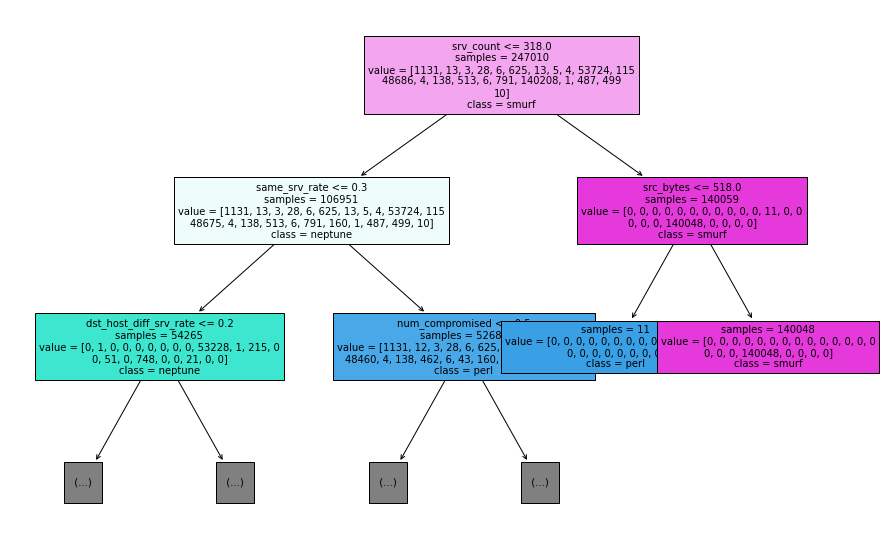

|--- srv_count <= 318.00
|   |--- same_srv_rate <= 0.33
|   |   |--- dst_host_diff_srv_rate <= 0.16
|   |   |   |--- truncated branch of depth 7
|   |   |--- dst_host_diff_srv_rate >  0.16
|   |   |   |--- truncated branch of depth 6
|   |--- same_srv_rate >  0.33
|   |   |--- num_compromised <= 0.50
|   |   |   |--- truncated branch of depth 30
|   |   |--- num_compromised >  0.50
|   |   |   |--- truncated branch of depth 6
|--- srv_count >  318.00
|   |--- src_bytes <= 518.00
|   |   |--- class: normal.
|   |--- src_bytes >  518.00
|   |   |--- class: smurf.



In [85]:
tree_txt = make_tree(x1, y1, x2, y2, targets)
print(tree_txt)

## Decision Tree 2

The first set (training) scores 0.9999919031945945
The second set (test) scores 0.9995506254807498


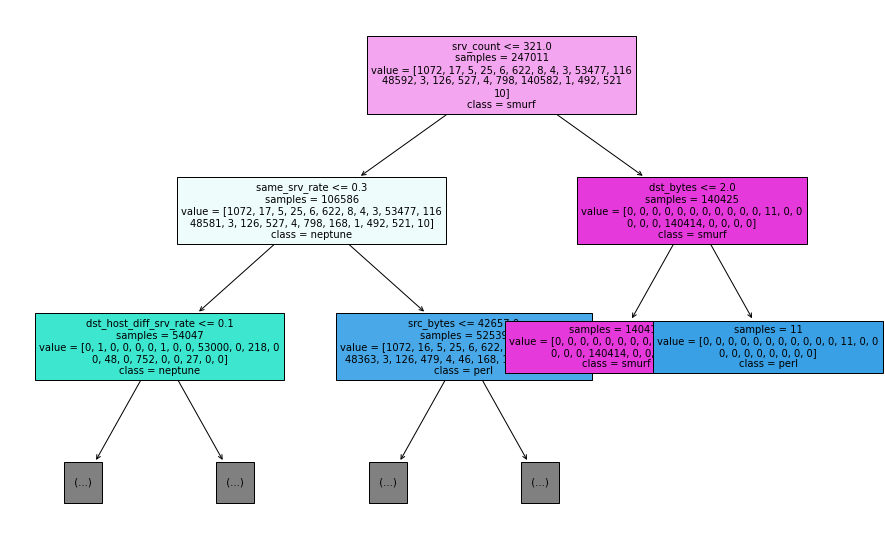

|--- srv_count <= 321.00
|   |--- same_srv_rate <= 0.33
|   |   |--- dst_host_diff_srv_rate <= 0.15
|   |   |   |--- truncated branch of depth 6
|   |   |--- dst_host_diff_srv_rate >  0.15
|   |   |   |--- truncated branch of depth 5
|   |--- same_srv_rate >  0.33
|   |   |--- src_bytes <= 42657.00
|   |   |   |--- truncated branch of depth 31
|   |   |--- src_bytes >  42657.00
|   |   |   |--- truncated branch of depth 3
|--- srv_count >  321.00
|   |--- dst_bytes <= 2.00
|   |   |--- class: smurf.
|   |--- dst_bytes >  2.00
|   |   |--- class: normal.



In [86]:
tree_txt2 = make_tree(x2, y2, x1, y1, targets)
print(tree_txt2)

## Comparing the Trees

I used `difflib` to create a side-by-side comparison for the two trees. Note that these are not the full trees but the trees truncated to 2 nodes past root. These two trees are very much alike, both starting with `srv_count` as the first decision point. The [task description](http://kdd.ics.uci.edu/databases/kddcup99/task.html) defines `srv_count` as _"number of connections to the same service as the current connection in the past two seconds"_.  It seems that both trees agree that if the serve count exceeds a threshold of about 318 connections then it is likely a __smurf__ attack or normal activity. The two trees differ on this second step with the first tree further classifying the records by `src_bytes` (_"number of data bytes from source to destination"_) and the second tree classifying them with `dst_bytes` (_"number of data bytes from destination to source"_). 	It is likely that these two variables are highly correlated. 

In [116]:
import difflib
from IPython.core.display import display, HTML
d = difflib.HtmlDiff().make_table(tree_txt.split('\n'), tree_txt2.split('\n'),
                                   fromdesc='Tree1', todesc='Tree2')
HTML(d)

## Class distribution

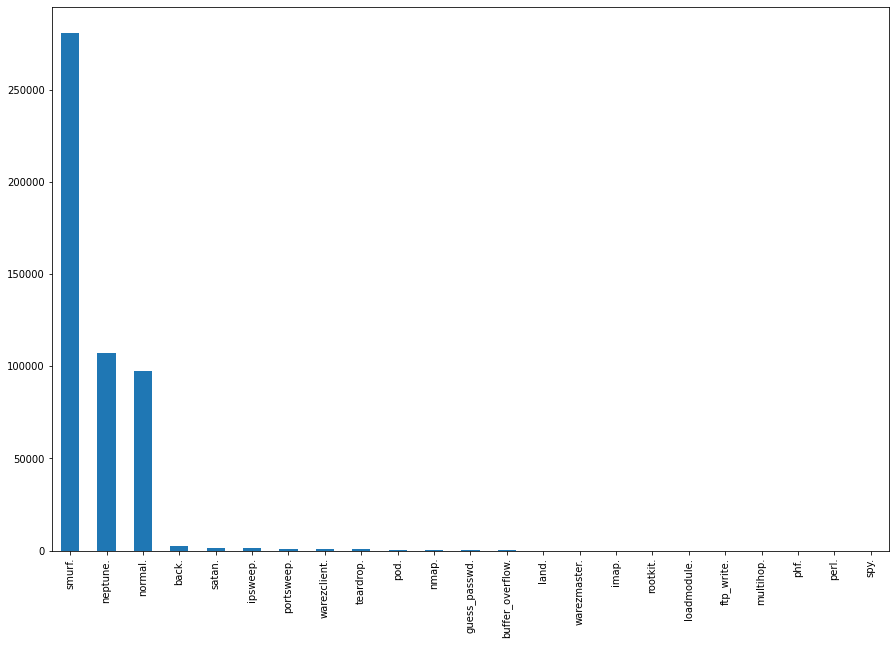

In [119]:
plt.figure(figsize=(15, 10))
kdd99_10p_df['attack_type'].value_counts().plot(kind="bar")